In [1]:
from src.dataset import MFCCDataset
from src.net import Net

import torchaudio
import torch
import os

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib notebook
import matplotlib.pyplot as plt

device = torch.device("cuda")

## Load Data

In [2]:
dataset = MFCCDataset(audio_dir="data/Audio",
                      label_dir="data/Labels",
                      device=device)

In [3]:
validation_split = 0.2

val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

## Define Network

In [4]:
class Net(nn.Module):
    def __init__(self, max_length):
        super(Net, self).__init__()
        self.max_length = max_length

        conv1_out_channels = 4
        conv1_kernel_size = (5, 5)
        conv1_stride = (1, 3)
        self.conv1_pool_size = (2, 3)
        self.conv1 = nn.Conv2d(
            1, conv1_out_channels, conv1_kernel_size, stride=conv1_stride
        )
        
        conv2_out_channels = 16
        conv2_kernel_size = (5, 5)
        conv2_stride = (1, 3)
        self.conv2_pool_size = (2, 3)
        self.conv2 = nn.Conv2d(
            4, conv2_out_channels, conv2_kernel_size, stride=conv2_stride
        )
        
        self.magic_num = 1 * 16 * 7 * 851
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(self.magic_num, 250)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(250, 4)
    
    def forward(self, x):
        # Input (x) shape: [input_channels (2), max_length]
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, self.conv1_pool_size)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, self.conv2_pool_size)
        # print(x.shape)
        x = x.view(-1, self.magic_num)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
    
net = Net(dataset.max_length)
net.cuda()
criterion = nn.MSELoss(reduction="sum").to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0)

# Train

In [5]:
train_loss_arr = []
val_loss_arr = []

In [7]:
dataset[0][0].shape

torch.Size([1, 40, 69003])

In [13]:
w, _ = torchaudio.load("data/Audio/One_Punch_Man_9.wav")
print(w.shape)
mfcc = torchaudio.transforms.MFCC(sample_rate=8000)(w)
print(mfcc.shape)

torch.Size([2, 11720534])
torch.Size([2, 40, 58603])


<IPython.core.display.Javascript object>


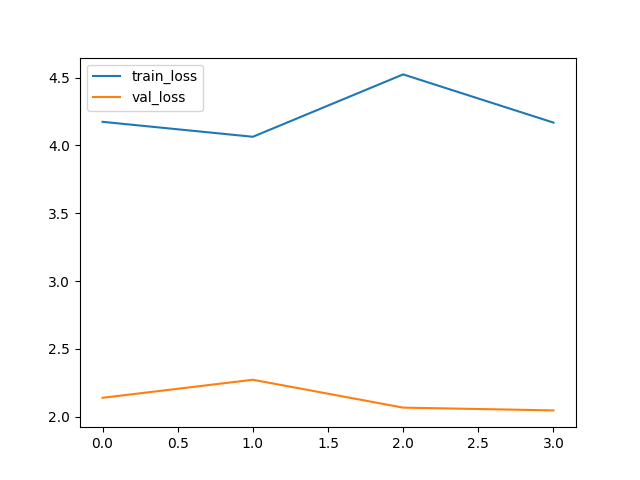

train_loss: 6.0633103509361925
val_loss: 2.0226555466651917
train_loss: 4.3038872463198805
val_loss: 2.068835417429606
train_loss: 4.24418829037593
val_loss: 2.097438335418701
train_loss: 4.1737583096210775
val_loss: 2.139734387397766
train_loss: 4.063559202047495
val_loss: 2.2726091543833413
train_loss: 4.523287479694073
val_loss: 2.067215303579966
train_loss: 4.168012398939866
val_loss: 2.0467502077420554


KeyboardInterrupt: 

In [6]:
batch_size = 5
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for epoch in range(10):

    train_loss = 0
    val_loss = 0
    
    net = net.train()
    for data, label in train_dataloader:

        optimizer.zero_grad()

        output = net(data)
        loss = criterion(output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    net = net.eval()
    for data, label in val_dataloader:
        output = net(data)
        loss = criterion(output, label)
        val_loss += loss.item()
        
    train_loss /= len(train_data)
    val_loss /= len(val_data)
    
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    
    ax.clear()
    if len(train_loss_arr) > 5:
        ax.plot(train_loss_arr[3:], label="train_loss")
        ax.plot(val_loss_arr[3:], label="val_loss")
    else:
        ax.plot(train_loss_arr, label="train_loss")
        ax.plot(val_loss_arr, label="val_loss")
    ax.legend()
    fig.canvas.draw()
    
    print("train_loss:", train_loss)
    print("val_loss:", val_loss)

In [ ]:
l_mean = dataset.l_mean.to(device)
l_std = dataset.l_std.to(device)

for i in range(20):
    filename = dataset.audio_filenames[i]
    audio_filename = os.path.splitext(filename)[0] + ".label"

    label = [0] * 4
    f = open("data/Labels/" + audio_filename)
    for i in range(4):
        label[i] = int(f.readline())
    label = torch.tensor(label).to(device)
    
    data, n_label = dataset[i]
    data = data.unsqueeze(0)

    pred = net(data)
    loss = criterion(pred, n_label).item()
    
    output = pred[0] * l_std + l_mean
    diff = ((output - label) / 1000).tolist()
    print(diff, loss)

# Compare actual labels

In [ ]:
label_1 = "data/Labels/nick/One_Punch_Man_1.label"
label_2 = "data/Labels/nick/One_Punch_Man_5.label"
label_3 = "data/Labels/nick/One_Punch_Man_6.label"

labels = []
for filename in [label_1, label_2, label_3]:
    f = open(filename, "r")
    label = []
    for i in range(4):
        label.append(int(f.readline()))
    labels.append(label)

labels = torch.Tensor(labels)
labels = labels.to(device)

In [ ]:
for i in range(len(anime_audio_data.audio_files)):
    if anime_audio_data.audio_files[i].startswith('One'):
        print(anime_audio_data.audio_files[i], i)

In [ ]:
'''
for i, data in enumerate(anime_audio_data):
    data, _ = data
    #data = data.unsqueeze(0)
    out = net(data) * anime_audio_data.l_std.to(device) + anime_audio_data.l_mean.to(device)
    print(out)
    print(labels[i])
'''
def temp(data):
    audio, label = data
    out = net(audio.unsqueeze(0)) * anime_audio_data.l_std.to(device) + anime_audio_data.l_mean.to(device)
    label = label * anime_audio_data.l_std.to(device) + anime_audio_data.l_mean.to(device)
    print(out)
    print(label)
temp(anime_audio_data[2])
temp(anime_audio_data[3])
temp(anime_audio_data[4])